# SWOP script 5 - Linear Mixed Effects Analysis
## 300-500 ms time window

This script imports a CSV file generated by the script *SWOP 4 - Measure ERPS* and performs linear mixed effects modelling.

Following general best practices, we are using **individual trial** data. Note that outliers (defined as data points at the level of subjets/trials/channels with abs(*z*) > 2.5) have been removed in script 4. 

A few technical notes:
- while LME is most commonly run using the *lmer()* function in the *lme4* package, we instead use the *bam()* function in the *mgcv* package. While mgcv/bam is written for generalized additive modelling, it allows for LME by using the *bs='re'* flag for smooths (where  're' stands for 'random effects'). The *bam()* function is parallelized, as well as being well-optimized, making it much faster to run, and without convergence errors that sometimes plague *lmer()* models
- best practices  in LME modelling tend to encourage full random effects models, and also by-item random effects and even random slopes for items within subjects. However, these models quickly become computationally very expensive, both in terms of time and RAM required. They are computed  here, but it is impossible to generate the tables of results and effet sizes with *emmeans()*, nor plot the contrasts of interest. My past experience, as well as experience with this dataset, is that these more elaborate random effects models do generate much smaller AIC values, and higher explained variance of the models. However, they do not in any appreciable way impact the general pattern of results (in terms of what's significant in the ANOVA tables, nor the effect sizes of our contrasts of interest). For these reasons, the models we ultimately present are not the "best" in the sense of AIC values or explained variance, but they tell efefctively the same story. For reference, however, the more complex models are computed and summarized here for reference. 

---
Copyright 2016-21  [Aaron J Newman](https://github.com/aaronjnewman), [NeuroCognitive Imaging Lab](http://ncil.science), [Dalhousie University](https://dal.ca)

Released under the [BSD 3-clause license](https://opensource.org/licenses/BSD-3-Clause)

---

## Load necessary libraries

In [1]:
date()

[1] "Mon Aug 30 00:03:57 2021"

In [2]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(mgcv)
library(parallel)
# library(viridis)
library(emmeans)
library(sjPlot)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.8-36. For overview type 'help("mgcv-package")'.

Registered S3 methods overwritten by 'parameters':
  method                           from      
  as.double.parameters_kurtosis    datawizard
  as.double.parameters_skewness    datawizard
  as.double.parameters_smoothness  datawizard
  as.numeric.parameters_kurtosis   datawizard
  as.numeric.parameters_skewness   datawizard
  as.numeric.parameters_smoothness datawizard
  print.parameters_distribution    datawizard
  print.parameters_kurtosis        datawizard
  print.parameters_skewness        datawizard
  summary.parameters_kurtosis      datawizard
  summary.parameters_skewness      datawizard



## Set parameters for this analysis

In [3]:
component = '300-500'
expt = 'SWOP'
data_path = '../group_data/'
out_path = '../results/'

data_file = paste(data_path, 'SWOP_ERP_measurements.csv', sep="")

# num parallel processes for bam(). Should be less than the number of threads supported by your CPU
num_cores = 14

options("scipen"=100, "digits"=5)  # force decimal instead of scientific notation

## Load Data

In [4]:
dat <- read.csv(data_file,
               colClasses=c('factor', 'numeric', 'factor', 
                            'factor', 'factor', 'factor', 
                            'factor',  'factor', 'factor', 
                            'numeric', 'factor', 'factor',
                            'factor', 'factor', 'factor', 
                            'factor', 'numeric', 'factor',
                            'numeric'
                           )
               )

dat$ROI <- factor(dat$ROI, levels=c('L_Ant', 'M_Ant', 'R_Ant',
                                       'L_Cent', 'M_Cent', 'R_Cent',
                                       'L_Post', 'M_Post', 'R_Post'
                                      ))

# specify ordering of condtiions, for plots and contrats
dat$Adverb <- factor(dat$Adverb, levels=c('kanske', 'hemma', 'idag'))
# Force contrasts as V3-V2
dat$SentPos <- factor(dat$SentPos, levels=c('V3', 'V2'))

### Select only data for ERP component of interest

In [5]:
dat <- subset(dat, Component==component | Component=='baseline')
dat <- droplevels(dat)

### Remove missing data 

In [6]:
dat <- dat[complete.cases(dat), ]

## Summary/Descriptives

In [7]:
summary(dat)

    Subject        Trial.Time          Condition          ROI       
 s_04nm : 6404   Min.   :   1157   V2/hemma :21018   L_Post :18909  
 s_18ak : 6335   1st Qu.: 499375   V2/idag  :20908   L_Cent :18877  
 s_19am : 6330   Median :1068687   V2/kanske:20957   R_Cent :18823  
 s_13ff : 6329   Mean   :1096223   V3/hemma :21086   R_Post :18796  
 s_21ma : 6327   3rd Qu.:1654384   V3/idag  :21011   R_Ant  :18729  
 s_26nm : 6324   Max.   :2977152   V3/kanske:21055   L_Ant  :18689  
 (Other):87986                                       (Other):13212  
    Channel         Sentence      postphrase  pronoun_noun questiondisplay.ACC
 TP8    : 4793   243    :   540   0.0:21006   N:63074      0: 20219           
 P7     : 4789   152    :   539   1.0:23121   P:62961      1:105816           
 TP7    : 4786   256    :   539   2.0:17379                                   
 T8     : 4779   409    :   539   3.0:25077                                   
 P8     : 4778   112    :   538   4.0:22445          

In [8]:
str(dat)

'data.frame':	126035 obs. of  19 variables:
 $ Subject            : Factor w/ 20 levels "s_04nm","s_07ba",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Trial.Time         : num  34102 34102 34102 34102 34102 ...
 $ Condition          : Factor w/ 6 levels "V2/hemma","V2/idag",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ ROI                : Factor w/ 9 levels "L_Ant","M_Ant",..: 1 1 1 1 4 4 4 4 7 7 ...
 $ Channel            : Factor w/ 27 levels "C3","C4","CP3",..: 6 8 10 12 1 3 24 26 15 17 ...
 $ Sentence           : Factor w/ 240 levels "10","101","102",..: 215 215 215 215 215 215 215 215 215 215 ...
 $ postphrase         : Factor w/ 6 levels "0.0","1.0","2.0",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ pronoun_noun       : Factor w/ 2 levels "N","P": 1 1 1 1 1 1 1 1 1 1 ...
 $ questiondisplay.ACC: Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ questiondisplay.RT : num  213 213 213 213 213 213 213 213 213 213 ...
 $ sentence_no        : Factor w/ 40 levels "1.0","10.0","11.0",..: 15 15 15 15 15 15 15 15 15 15 ...
 $ s

## Get counts of trials in each cell of design
We select data from Cz just to avoid repeated measures for all the electrodes

In [9]:
crosstab <- xtabs(~ SentPos + Adverb, data=subset(dat, Component==component & Channel=='Cz'))
ftable(crosstab) # print table 
summary(crosstab) #

        Adverb kanske hemma idag
SentPos                         
V3                724   724  733
V2                711   723  710

Call: xtabs(formula = ~SentPos + Adverb, data = subset(dat, Component == 
    component & Channel == "Cz"))
Number of cases in table: 4325 
Number of factors: 2 
Test for independence of all factors:
	Chisq = 0.169, df = 2, p-value = 0.92

### Visualize distributions

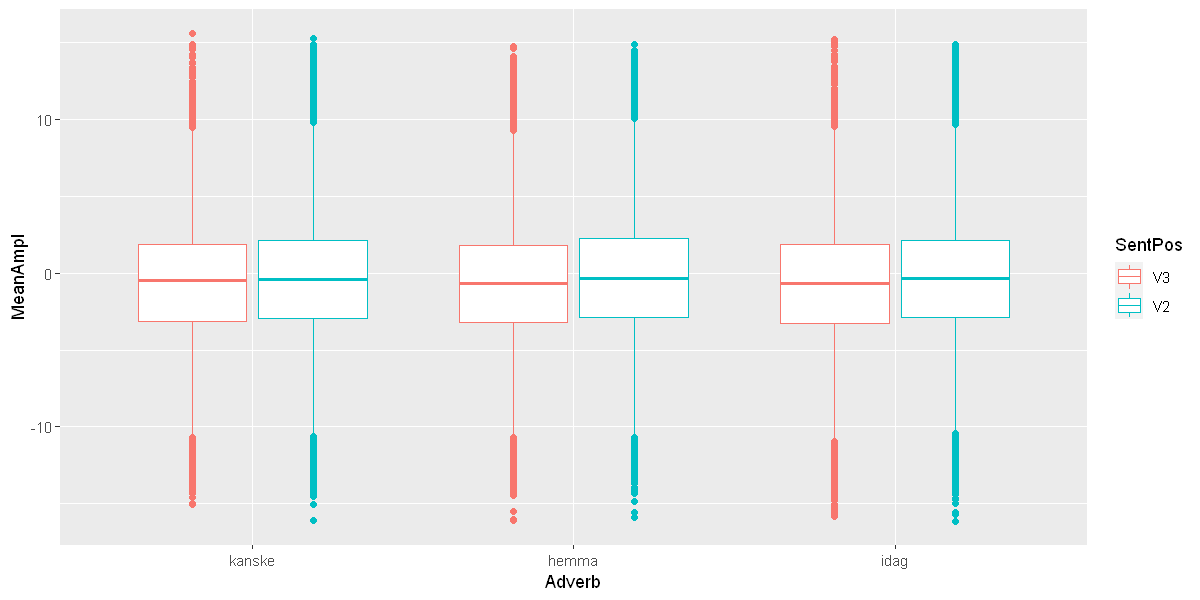

In [10]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(dat, aes(y=MeanAmpl, x=Adverb, col=SentPos)) + 
    geom_boxplot() 

## LME modelling

Note: we use the `bam()` function but fit linear models.

### Fit a simple-but-full model without baseline

In [11]:
cl <- makeCluster(num_cores)  

m0 <- bam(MeanAmpl ~ (Adverb * SentPos * ROI)
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

In [ ]:
gam.check(m0)

In [ ]:
anova(m0)

## Include baseline as fixed effect, not interacting with other factors

In [ ]:
cl <- makeCluster(num_cores)  

m_b_nox <- bam(MeanAmpl ~ (Adverb * SentPos * ROI) + baseline
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Include baseline as a fixed effect, *fully interacting* with other factors

In [ ]:
cl <- makeCluster(num_cores)  

m_full <- bam(MeanAmpl ~ (Adverb * SentPos * ROI * baseline)
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Add random intercepts for items (sentences) as well as subjects

In [ ]:
cl <- makeCluster(num_cores)  

mf_4w_rei <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Allow only 3-way interactions

In [ ]:
cl <- makeCluster(num_cores)  

mf_3w_rei <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^3
          + s(Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Random slopes for items (sentences) within subjects, and random slopes for Channel within subjects, 4 way interactions

This takes a long time to fit, and requires lots of RAM

In [ ]:
cl <- makeCluster(num_cores)  

mf_4w_recsis <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Channel, Subject, bs='re') + s(Sentence, Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Random slopes for items (sentences) within subjects, and random slopes for Channel within subjects, 3 way interactions

In [ ]:
cl <- makeCluster(num_cores)  

mf_3w_recsis <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^3
          + s(Channel, Subject, bs='re') + s(Sentence, Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

## Random intercepts by item, not nested in subjects

In [ ]:
cl <- makeCluster(num_cores)  

mf_4w_reci <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Channel, Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

## Compare models

In [ ]:
AICtab <- as.data.frame(AIC(m0, m_full, m_b_nox, 
                            mf_3w_rei, mf_3w_recsis,
                            mf_4w_rei, mf_4w_recsis, mf_4w_reci
                           )) 
AICtab$deltaAIC <-AICtab$AIC - min(AICtab$AIC)
AICtab[order(AICtab$AIC),]

---
## Explore best model

### Best Model

**`mf_4w_recsis`** has smallest AIC

However, the random effects structure is so complex that we can't generate plots of this model below (requires more RAM than we have; takes > 24 h to fit and then maybe crashes). For those we use the model **`mf_4w_reci`**, which is the same but with only random intercepts by sentence, not sentence-by-subject RE

The plotted effect sizes and confidence intervals do not change in any visually-detectable way between these models with different random effects structures anyway.

In [ ]:
anova(mf_4w_recsis)

### Write ANOVA table to text file

In [ ]:
capture.output(anova(mf_4w_recsis), file=paste(out_path, 'anova_table_', component, '.txt'))

In [ ]:
summary(mf_4w_recsis)

### View the model that gives best AIC, within computational feasibility

In [ ]:
mod = mf_4w_rei #mf_4w_rei

In [ ]:
anova(mod)

In [ ]:
summary(mod)

## View results

In [ ]:
contr <- emmeans(mod,  pairwise ~ SentPos | Adverb * ROI)

contr_tab = contr$contrasts %>% as.data.frame()
ncomp = nrow(contr_tab)
contr_tab$'p (raw)'   = round(contr_tab$'p.value', 4)
contr_tab$'p (FDR BH)' = round(p.adjust(contr_tab$'p.value', method = 'BH', n = ncomp), 4)
contr_tab <- subset(contr_tab, select=-c(p.value))
contr_tab

## Get effect sizes on differences 
Cohen's *d*

### Plot effect sizes for all V3-V2 contrasts

Also save a PDF version of the plot

In [ ]:
pdf(paste(out_path, 'figures/R plots/', 'lme_effect_plot_', component, '.pdf', sep="")) 
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))
dev.off() 
options(repr.plot.width=24, repr.plot.height=16)
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))

In [ ]:
eff_tab <- eff_size(contr, sigma = sigma(mod), edf = 125000) %>% as.data.frame()
full_tab <- contr_tab %>% full_join(eff_tab, by=c("ROI", 'Adverb'), suffix = c(".ctr", ".eff"))
full_tab

### Write above table to file

In [ ]:
write.csv(full_tab, file=paste(out_path, 'contrast_table_', component, '.csv' ,sep=''))

## Plot Model

In [ ]:
# save PDF
pdf(paste(out_path, 'figures/R plots/', 'lme_model_plot_', component, '.pdf', sep="")) 
plot_model(mod, 
           type='emm',
           terms=c('Adverb', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )
dev.off() 

# plot in this notebook
options(repr.plot.width=16, repr.plot.height=16)
plot_model(mod, 
           type='emm',
           terms=c('Adverb', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )

In [ ]:
date()